# NMA Robolympics: Controlling robots using reinforcement learning

**By Neuromatch Academy**

__Content creators:__ Roman Vaxenburg, Diptodip Deb, Srinivas Turaga

__Production editors:__ Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objectives

This notebook provides a minimal but complete example of the reinforcement learning infrastructure, training sequence, and result visualization. We will use a [pybullet](https://github.com/bulletphysics/bullet3) locomotion environment and [dm-acme](https://github.com/deepmind/acme) reinforcement learning agents to learn a policy to perform a simple task with the 2D `Hopper` robot. 

We will show how to create and inspect the environment and how to start modifying it to have robots perform various tasks. This example should provide a good starting point for your own exploration!

Even though this example uses a very simple robot, you can start experimenting with more complicated ones, such as `Ant` and `Humanoid` by just importing and modifying them as shown in this example. Also, start exploring the source code of the environments so you can modify them more easily later.

We would also suggest going over the `dm-acme` tutorial notebook:

https://github.com/deepmind/acme/blob/master/examples/tutorial.ipynb

For a general introduction to Reinforcement Learning, it's worth checking out this course:

https://deepmind.com/learning-resources/-introduction-reinforcement-learning-david-silver


# Colab limits

Please note that due to the Colab usage limits on the one hand, and the compute requirements of the project on the other hand, most likely you won't be able to leverage Colab's GPU for a sufficient amount of time. Instead, we suggest working in CPU-only mode (it shouldn't slow you down very much, typical RL workloads are CPU-bound anyway). Make sure you're not using GPU by doing Runtime -> Change runtime type -> Hardware accelerator -> None.

Also, when instantiating the environments, make sure to keep the default setting `render=False`.

---
# Setup

In [1]:
# @title Install dependencies
# @markdown In the first cell we'll install all of the necessary dependencies.
from IPython.display import clear_output
# !sudo apt-get -q install ffmpeg freeglut3-dev xvfb  # For visualization.
import getpass
import os

# password = getpass.getpass()
# command = "sudo -S apt-get -q install ffmpeg freeglut3-dev xvfb" #can be any command but don't forget -S as it enables input from stdin
# os.system('echo %s | %s' % (password, command))
# !pip install tensorflow --quiet
# !pip install dm-sonnet --quiet
# !pip install imageio-ffmpeg --quiet
# !pip install pybullet --quiet
# !pip install dm-acme[tf]==0.2.0 dm-acme[reverb]==0.2.0 --quiet

clear_output()

In [26]:
# !pip install matplotlib
# !pip install gym
# !pip install jax
# !pip install --upgrade pip
# !pip install --upgrade "jax[cpu]"
# !git clone http://github.com/bulletphysics/bullet3
clear_output()

In [2]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs
import pybullet as p 
import pybullet_data
import time

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from google.colab import drive
from IPython.display import HTML

from pybullet_utils import bullet_client

In [3]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv
from pybullet_envs.scene_stadium import SinglePlayerStadiumScene

In [4]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

---
# Functions for saving and restoring checkpoints
Due to Colab usage limits, the Colab runtime will be restarting periodically. In order to preserve the most recent training checkpoint during a restart, please use the functions below.

To do so, you'll have to first mount Google Drive (will be shown below).

### Before runtime restart:
Use `save_ckpt_to_drive` to locate the checkpoint and save it to your Google Drive in a directory `/acme_ckpt`

### After runtime restart:
Use `restore_ckpt_from_drive` to recover the checkpoint from Google Drive and copy it back to the restarted Colab virtual machine.

In [5]:
def save_ckpt_to_drive(agent, dst = '/root/drive/MyDrive/acme_ckpt'):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the 
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  # dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent, src = '/root/drive/MyDrive/acme_ckpt'):
  """Restores agent checkpoint directory from Google Drive.
  
  The name of the local checkpoint directory will be different 
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  # src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

---
# Convenience function for creating videos

Use this function to generate videos of your experiments.

In [6]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

---
# Network factory methods for select continuous control agents
The functions below initialize and return the policy and critic networks for several continuous control agents (DDPG, D4PG, DMPO) used later in this notebook. Feel free to explore other agents as well. For more information on these and other agents, their implementations, and links to their corresponding papers see
https://github.com/deepmind/acme/tree/master/acme/agents

Please note that the hyperparameters `layer_sizes`, `vmin`, `vmax`, `num_atoms` are set to reasonable default values, but may reqiure adjustment. Especially, `vmin` and `vmax` should be used with care. Please see, e.g., https://github.com/deepmind/acme/blob/master/acme/agents/tf/d4pg/README.md for more information.

In [7]:
def make_networks_d4pg(action_spec,
                      #  policy_layer_sizes=(256, 256, 256),
                      #  critic_layer_sizes=(512, 512, 256),
                       policy_layer_sizes=(256, 256),
                       critic_layer_sizes=(512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin, 
                                  vmax=vmax, 
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

---
# List of all `pybullet` environments

You can print the full list of environments by running the cell below. Only a subset of them are locomotion environments but feel free to explore the other ones if you're interested.

In [17]:
pybullet_envs.getList()

['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

---
# Modifying the environment base class

You may start your exploration of the `pybullet` locomotion environment code from this entry point, going up and down the hierarchy of classes:

https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py

For our experiments, we will be using the `pybullet` locomotion environments with several different robots (`Hopper`, `Ant`, `Humanoid`, etc.). In order to have the robots perform different tasks, we'll need to modify some parts of the environments' code. This will (mainly) amount to modifying the environments' reward calculation in the `step` method.

In the cell below we provide a minimal example modifying the `HopperBulletEnv` environment class. Normally, to create a Hopper environment you would just create an instance of the HopperBulletEnv class:

```
env = HopperBulletEnv()
```
However, if you analyze the environment's code, you'll realize that making changes (such as modifying the reward calculation) is difficult in this way. Instead, it's useful to create a custom child class inheriting from the original `HopperBulletEnv` class and override some of its methods. This subclassing will allow you to easily access the interesting pieces of the environment class to modify.

In the example of a custom `Hopper` class below, we override several methods of its parent class to (i) make the reward calculation modifiable, (ii) add `step_counter` to enforce fixed episode duration, and (iii) make the episode termination conditions modifiable. Please note that in some cases the overriding methods still call their parent methods after executing the required modifications (such as the `__init__`, `reset`, `_isDone` methods do.). In contrast, the `step` method is overriden in its entirety and doesn't reference its parent method. So instead of the code line above, the environment would be created as:
```python
env = Hopper()
```
You can use this approach and this example as the starting point of your project. In many cases, this custom class can be used as is (with only a name change) with other robots in the `pybullet` locomotion environments by inheriting from their respective original environment classes instead of from `HopperBulletEnv`.

In [8]:
class Hopper(HopperBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    # if render:
    #   self._p = bullet_client.BulletClient(connection_mode=pybullet.GUI)
    # else:
    #   self._p = bullet_client.BulletClient()
    # self.scene = HopperBulletEnv.create_single_player_scene(self, self._p)
    # self.scene.zero_at_running_strip_start_line = False
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())
  
  def create_single_player_scene(self, bullet_client):
    s = HopperBulletEnv.create_single_player_scene(self, bullet_client)
    s.zero_at_running_strip_start_line = False
    return s
  
  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots, 
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      # print(self.ground_ids)
      # print(contact_ids)
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0
    # print(self.robot.feet_contact)
    ###### MY OWN CODE (THITI) #######################################
    # jump = 1.0 if self.robot.feet_contact > 0 else 0.0
    # jump = 0.0 if self.robot.feet_contact > 0 else 1.0

    jump = 0.0
    # how_far = np.sqrt(self.robot.walk_target_x**2 + self.robot.walk_target_y**2) \
              # - self.robot.walk_target_dist
    # how_far = self.robot.walk_target_dist \
    #           - np.sqrt(self.robot.walk_target_x**2 + self.robot.walk_target_y**2)
    how_far = 0.0
    # uprightness
    # print(self.robot.body_rpy)
    # print(how_far)
    # print(np.sqrt(self.robot.walk_target_x**2 + self.robot.walk_target_y**2))
    # print(self.robot.walk_target_dist)
    # DEFINE LOSS FUNCTION and plot that
    ##################################################################
    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost, 
                    joints_at_limit_cost, feet_collision_cost,
                    jump, how_far
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)
    return state, sum(self.rewards), bool(done), {}

## Test on Humanoid

In [16]:
class Humanoid(HumanoidBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    # if render:
    #   self._p = bullet_client.BulletClient(connection_mode=pybullet.GUI)
    # else:
    #   self._p = bullet_client.BulletClient()
    # self.scene = HopperBulletEnv.create_single_player_scene(self, self._p)
    # self.scene.zero_at_running_strip_start_line = False
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())
  
  def create_single_player_scene(self, bullet_client):
    s = HopperBulletEnv.create_single_player_scene(self, bullet_client)
    s.zero_at_running_strip_start_line = False
    return s
  
  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots, 
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      # print(self.ground_ids)
      # print(contact_ids)
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0
    # print(self.robot.feet_contact)
    ###### MY OWN CODE (THITI) #######################################
    # jump = 1.0 if self.robot.feet_contact > 0 else 0.0
    # jump = 0.0 if self.robot.feet_contact > 0 else 1.0

    jump = 0.0
    # how_far = np.sqrt(self.robot.walk_target_x**2 + self.robot.walk_target_y**2) \
              # - self.robot.walk_target_dist
    # how_far = self.robot.walk_target_dist \
    #           - np.sqrt(self.robot.walk_target_x**2 + self.robot.walk_target_y**2)
    how_far = 0.0
    # uprightness
    # print(self.robot.body_rpy)
    # print(how_far)
    # print(np.sqrt(self.robot.walk_target_x**2 + self.robot.walk_target_y**2))
    # print(self.robot.walk_target_dist)
    # DEFINE LOSS FUNCTION and plot that
    ##################################################################
    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost, 
                    joints_at_limit_cost, feet_collision_cost,
                    jump, how_far
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)
    return state, sum(self.rewards), bool(done), {}

In [21]:
env_hum = Humanoid(render=False)

env_hum = wrappers.GymWrapper(env_hum)
env_hum = wrappers.SinglePrecisionWrapper(env_hum)

action_spec_hum = env_hum.action_spec()  # Specifies action shape and dimensions.
env_spec_hum = specs.make_environment_spec(env_hum)  # Environment specifications.
print(action_spec_hum)

BoundedArray(shape=(17,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.])


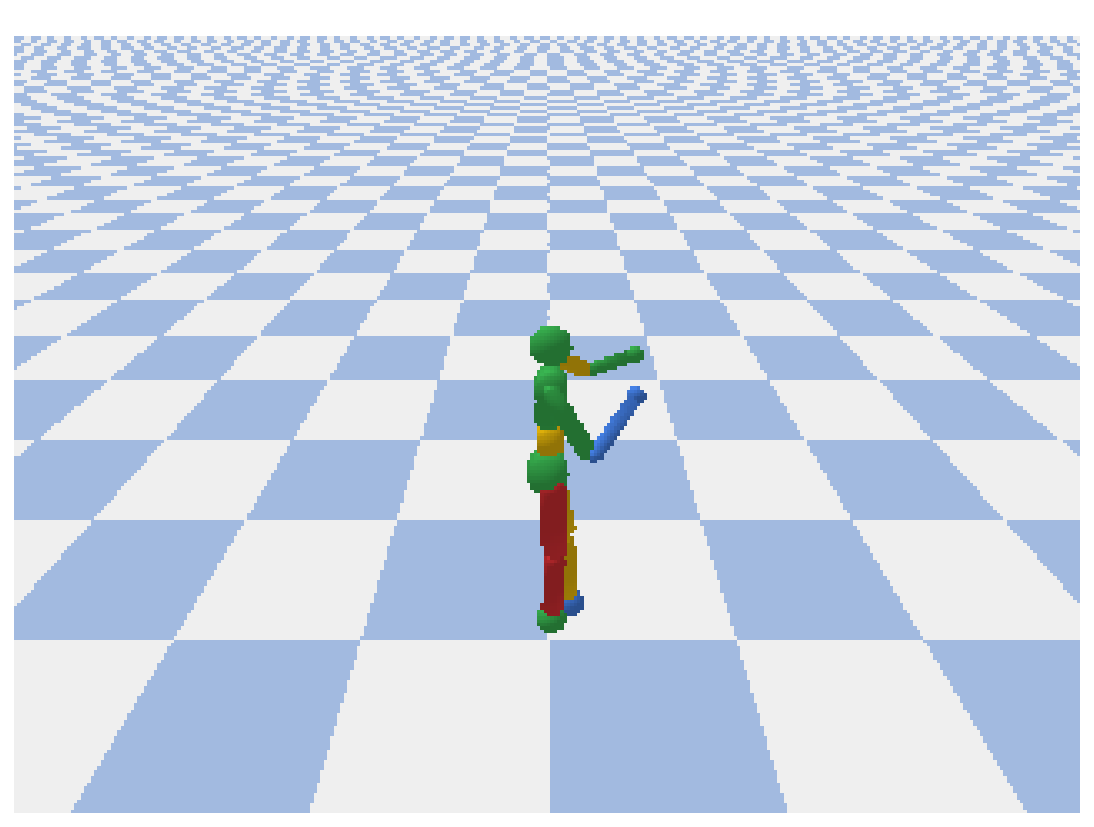

In [18]:
_ = env_hum.reset()

frame = env_hum.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [34]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 300
# print(action_spec.shape)
frames = []
timestep = env_hum.reset()
### TEST
# env.robot.ordered_joints[1].power_coef = 100
###
for _ in range(n_steps):
  # Random control of actuators.
  action = np.random.uniform(action_spec_hum.minimum,
                             action_spec_hum.maximum,
                             size=action_spec_hum.shape)
  # action = np.array([0.5, 0, 0])
  # action = np.array([0, 0.5, 0])
#   action = np.array([0, 0, 1]) #accumulated ... of 3 directions?
  # print(action)
  timestep = env_hum.step(action)
  # print(env.rewards)
  # print(env.robot.feet[0].contact_list())
  print(env_hum.robot.feet[0].current_position())
  frames.append(env_hum.environment.render(mode='rgb_array'))
# print(frames)
# print(type(timestep))
# print(timestep)
display_video(frames, framerate=30)

[0.03967975 0.02484399 0.20596176]
[0.02893751 0.00340668 0.20272065]
[ 0.01087033 -0.01962585  0.20594443]
[-0.01294641 -0.03294239  0.21436174]
[-0.03098969 -0.04020709  0.22284767]
[-0.05074506 -0.05123899  0.25157307]
[-0.07260499 -0.06300928  0.30135624]
[-0.09672374 -0.06791524  0.3595827 ]
[-0.1141069  -0.07114863  0.43051329]
[-0.12130893 -0.0696441   0.50072939]
[-0.12202068 -0.06662525  0.55871135]
[-0.11608682 -0.06985145  0.61623706]
[-0.09343254 -0.06154221  0.66769245]
[-0.09605404 -0.05865286  0.6228117 ]
[-0.1135904  -0.07163981  0.57229784]
[-0.13594592 -0.08083322  0.52391373]
[-0.15051675 -0.07251262  0.47787489]
[-0.16288827 -0.06742345  0.43481742]
[-0.16181241 -0.07250932  0.40134528]
[-0.14156417 -0.08010526  0.37230054]
[-0.01570918 -0.09363181  0.20935741]
[-0.01695784 -0.09998876  0.20703339]
[-0.03554651 -0.10747555  0.19943685]
[-0.0642208  -0.10010359  0.19740072]
[-0.0912699  -0.0830196   0.20970437]
[-0.12045238 -0.06582967  0.23812781]
[-0.14879426 -0.05

In [25]:
print('Actions:\n', env_spec_hum.actions)
print('Observations:\n', env_spec_hum.observations)
print('Rewards:\n', env_spec_hum.rewards)

Actions:
 BoundedArray(shape=(17,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.])
Observations:
 BoundedArray(shape=(44,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


In [38]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint_hum = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

In [39]:
# Create networks.
policy_network_hum, critic_network_hum = make_networks_d4pg(action_spec_hum)

# Create agent.
agent_hum = D4PG(environment_spec=env_spec_hum,
             policy_network=policy_network_hum,
             critic_network=critic_network_hum,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint_hum)

ValueError: Shapes (61, 512) and (18, 512) are incompatible

In [31]:
help(tf2_utils.batch_concat)

Help on function batch_concat in module acme.tf.utils:

batch_concat(inputs:Any) -> tensorflow.python.framework.ops.Tensor
    Concatenate a collection of Tensors while preserving the batch dimension.
    
    This takes a potentially nested collection of tensors, flattens everything
    but the batch (first) dimension, and concatenates along the resulting data
    (second) dimension.
    
    Args:
      inputs: a tensor or nested collection of tensors.
    
    Returns:
      A concatenated tensor which maintains the batch dimension but concatenates
      all other data along the flattened second dimension.



---
# Instantiate the environment

Here, we are creating an example `Hopper` environment. Once created, we are wrapping it with `GymWrapper` to make the native `Gym` environment interface compatible with the one used in the `dm-acme` library, which is the reinforcement learning package that we will be using. `dm-acme` adheres to the interface defined here: https://github.com/deepmind/dm_env. Finally, we also use `SinglePrecisionWrapper` to enforce single-precision on a potentially double-precision environment.


In [27]:
env = Hopper(render=False)

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

In [ ]:
env.create_single_player_scene

---
# The default task

If not modified, the default task of the `HopperBulletEnv` environment is to have the robot hop to the target location located 1 km away. The target location is stored as an attribute of the `robot` object and can be accessed as in the cell below.

The task also contains other constraints, such as `electricity_cost`, and certain episode termination conditions. Please start from our custom `Hopper` class in the above cell and work your way backwards to the the environment code for more details!

In [ ]:
# x and y coordinates of the target location.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

---
# Let's inspect the environment a bit

#### Plot one frame of the environment

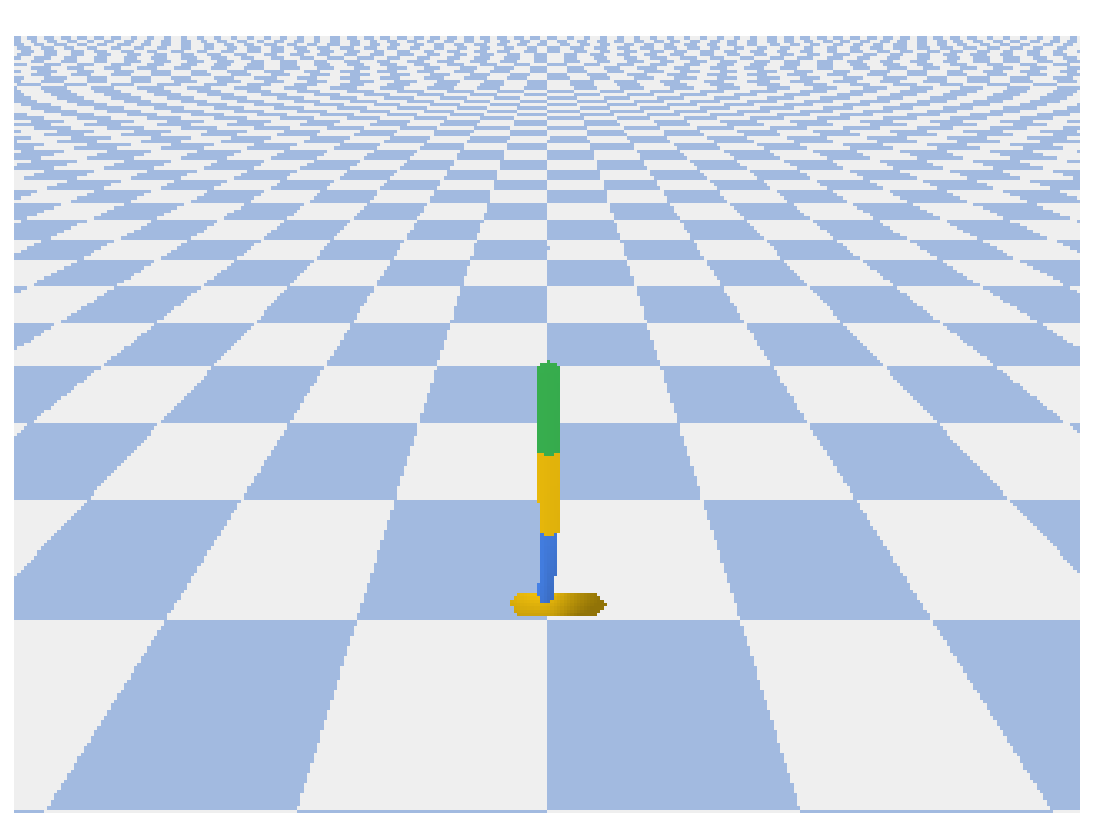

In [20]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [21]:
import gym
env = gym.make('CartPole-v0')
env.reset()

for i in range(1000):
    env.step(env.action_space.sample())
    env.render()

/home/tpremrud/proj1/proj1_env/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [43]:
import pybullet as p
import pybullet_data
physicsClient = p.connect(p.DIRECT)#or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #used by loadURDF
p.setGravity(0,0,-10)
planeId = p.loadURDF("plane.urdf")
cubeStartPos = [0,0,1]
cubeStartOrientation = p.getQuaternionFromEuler([0,0,0])
boxId = p.loadURDF("r2d2.urdf",cubeStartPos, cubeStartOrientation)
p.stepSimulation()
cubePos, cubeOrn = p.getBasePositionAndOrientation(boxId)
print(cubePos,cubeOrn)
p.disconnect()

(1.2618370655997593e-21, 1.0619299914168979e-24, 0.9998263888888889) (4.801806680334471e-22, 6.571396703901434e-21, 1.992821649693796e-22, 1.0)


In [50]:
cd '/home/tpremrud/proj1/NMA DL/robolympics-main'

'/home/tpremrud/proj1/NMA DL'

In [44]:
### TEST to render stadium
import pybullet as p
import time

p.connect(p.DIRECT)
p.resetSimulation()
# p.connect(p.DIRECT)
# p.connect(p.SHARED_MEMORY,1234)
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#don't create a ground plane, to allow for gaps etc
p.resetSimulation()
#p.createCollisionShape(p.GEOM_PLANE)
#p.createMultiBody(0,0)
#p.resetDebugVisualizerCamera(5,75,-26,[0,0,1]);

# set a fixed camera
# p.resetDebugVisualizerCamera(15, -346, -16, [-15, 0, 1])

p.loadSDF('stadium.sdf')
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING, 0)

# env = Humanoid(render=True)
# env = wrappers.GymWrapper(env)
# env = wrappers.SinglePrecisionWrapper(env)
#
# action_spec = env.action_spec()  # Specifies action shape and dimensions.
# env_spec = specs.make_environment_spec(env)  # Environment specifications.
# env.robot.walk_target_x, env.robot.walk_target_y = 300, 0
# print("heyyyy", env.robot.walk_target_x, env.robot.walk_target_y)

cubeStartPos = [0,-1,1]
cubeStartOrientation = p.getQuaternionFromEuler([0,-1,0])
# humanoidId = p.loadURDF("humanoid.urdf",cubeStartPos, cubeStartOrientation)
p.setGravity(0,0,-5)
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING, 1)

i = 0
while (i < 500):
    p.stepSimulation()
    time.sleep(1./240.)
    # camData = p.getDebugVisualizerCamera()
    # viewMat = camData[2]
    # projMat = camData[3]
    # p.getCameraImage(256,
    #                256,
    #                viewMatrix=viewMat,
    #                projectionMatrix=projMat,
    #                renderer=p.ER_BULLET_HARDWARE_OPENGL)
    keys = p.getKeyboardEvents()
    p.stepSimulation()
    i += 1
    #print(keys)
p.disconnect()

error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

## Run the environment with random actions

We haven't trained the policy yet, but we can still see the environment in action by passing a random control sequence to it.

In [40]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 10
# print(action_spec.shape)
frames = []
timestep = env.reset()
### TEST
# env.robot.ordered_joints[1].power_coef = 100
###
for _ in range(n_steps):
  # Random control of actuators.
  # action = np.random.uniform(action_spec.minimum,
  #                            action_spec.maximum,
  #                            size=action_spec.shape)
  # action = np.array([0.5, 0, 0])
  # action = np.array([0, 0.5, 0])
  action = np.array([0, 0, 1]) #accumulated ... of 3 directions?
  # print(action)
  timestep = env.step(action)
  # print(env.rewards)
  # print(env.robot.feet[0].contact_list())
  print(env.robot.feet[0].current_position())
  frames.append(env.environment.render(mode='rgb_array'))
# print(frames)
# print(type(timestep))
# print(timestep)
display_video(frames, framerate=1)

[-0.00994721  0.          0.10032219]
[-0.01928312  0.          0.1046558 ]
[-0.03244155  0.          0.11808585]
[-0.04999038  0.          0.14461504]
[-0.05640885  0.          0.1564058 ]
[-0.06272832  0.          0.16722078]
[-0.06875529  0.          0.17671967]
[-0.07441606  0.          0.18466677]
[-0.07968688  0.          0.19088716]
[-0.0845653   0.          0.19524372]


In [38]:
help(env.robot.parts['torso'].pose())


AttributeError: 'CartPoleEnv' object has no attribute 'robot'

In [ ]:
print(env.robot.parts['torso'].pose().rpy())
print(env.robot.parts['torso'].pose().xyz())
print(env.robot.parts['torso'].pose().orientation())

(0.0, -0.6889395566255972, 0.0)
[-0.03071879  0.          1.18719291]
[ 0.         -0.33769765  0.          0.94125464]


In [ ]:
print(env.robot.feet[0].contact_list())
print(env.robot.feet[0].current_position())
print(env.robot.feet[0].get_position())
print(env.robot.feet[0].get_pose())

()
[0.053246   0.         0.21948694]
[0.053246   0.         0.21948694]
[ 0.053246    0.          0.21948694  0.         -0.09032198  0.
  0.99591262]


In [ ]:
env.robot.walk_target_dist

999.7281796863562

In [ ]:
print(env.robot.calc_state())
print(env.rewards)
print(env.joints_at_limit_cost)
print(env.robot.joints_at_limit)
print(env.robot.feet_contact)
# print(action_spec)

[-6.2807083e-02  0.0000000e+00  1.0000000e+00 -1.7858421e-02
  0.0000000e+00 -4.1506609e-01  0.0000000e+00 -6.8893957e-01
  7.6923519e-01 -4.2905328e-01  2.1462049e-01 -4.5613036e-01
  1.0001720e+00 -8.1859401e-04  0.0000000e+00]
[1.0, 1.5564480261309654, -0.033879062673076984, -0.1, 0.0, 1.0, 0.2718203136438433]
-0.1
1
[0.]


In [ ]:
j = env.robot.calc_state()[8:-1]
print(j)
# np.concatenate([j] + [np.array([1,2,3])])
# type(env.robot.ordered_joints)
print(j[0::2])  # even indices ==> position
print(j[1::2])  # odd indices ==> angular apeed
print(env.robot.ordered_joints)
print(env.robot.ordered_joints[0].current_relative_position())
print(env.robot.ordered_joints[1].current_relative_position())
print(env.robot.ordered_joints[2].current_relative_position())
print(env.robot.ordered_joints[0].power_coef)
print(env.robot.ordered_joints[1].power_coef)
print(env.robot.ordered_joints[2].power_coef)
print(env.robot.power)

[ 7.6923519e-01 -4.2905328e-01  2.1462049e-01 -4.5613036e-01
  1.0001720e+00 -8.1859401e-04]
[0.7692352  0.21462049 1.000172  ]
[-0.42905328 -0.45613036 -0.00081859]
[<robot_bases.Joint object at 0x7f4b34177e50>, <robot_bases.Joint object at 0x7f4b34177ed0>, <robot_bases.Joint object at 0x7f4b33cfa110>]
(0.7692351840649828, -0.4290532667041155)
(0.21462048089315022, -0.4561303671798238)
(1.0001719739288528, -0.0008185940098904388)
100.0
100.0
100.0
0.75


In [ ]:
for n, j in enumerate(env.robot.ordered_joints):
  print(n, j)

0 <robot_bases.Joint object at 0x7f4b34177e50>
1 <robot_bases.Joint object at 0x7f4b34177ed0>
2 <robot_bases.Joint object at 0x7f4b33cfa110>


In [ ]:
print(env.robot.body_xyz)
print(env.robot.body_real_xyz)
print(env.robot.body_rpy)
print(env.robot.walk_target_theta)


(0.27182031364381093, 0.0, 1.187192914097806)
[-0.03071879  0.          1.18719291]
(0.0, -0.6889395566255972, 0.0)
0.0


## Notes
* `env.robot.calc_state` 
* `j` is the array of the position and angular speed of the joints (?) &#8594; even elements (`j[0::2]`) are the position and odd elements (`j[1::2]`) are the angular speed, both scaled to -1,+1
  * If any position exceeds 0.99 &#8594; Impose a cost as `joints_at_limit` element of the overall cost in reward function.
* `env.robot.ordered_joints` has an attribute `current_relative_position` which define the position and angular speed, and thus defining the variable `j`
  * This `current_relative_position` got the position and velocity from `self.get_state()` &#8594; Comes from `self._p.getJointState(self.bodies[self.bodyIndex], self.jointIndex)`, but can't figure out what `_p` is yet :(
  * I think this `current_relative_position` is the current relative position (duh) for x, y, and z axis, respectively
* `env.robot.apply_action(a)` uses the object `env.robot.ordered_joints` which contains the attribute of `set_motor_torque`, which takes an input of `self.power * j.power_coef * float(np.clip(a[n], -1, +1))`

## Questions
* What are the differences between `robot_locomotors.py` and `gym_locomotion_envs.py` ? This is because the name of the class are WalkerBaseBulletEnv and WalkerBase, respectively. (I think it's the setup of the environment, and the setup of the robot itself)
* What are `bullet_client`s stuff in the MJCFBasedRobot class?

## Guesses Based on Findings
* `set_motor_torque` might be our key to victory
  * The `j.power_coef` equals to 0 unless the joint name is not equal to 'jointfix' (refer to the addToScene function in 'XmlBasedRobot' case) &#8594; it becomes 100
  * `self.power` needs attention also, since it is being initialized in the __init__ function &#8594; If we can somehow get this power to be initialized for the agent/robot, as a jumpstart, that would definitely be something. &#8594; However, from what I see, the Hopper robot class is being applied from the usage of HopperBulletEnv already, which has a power of 0.75 &#8594; leaving us with the `power_coef` issue

## TODO
* Check out `move_robot(self, init_x, init_y, init_z)` function in `WalkerBaseBulletEnv` class
* Make sure you understand the `addToScene` function, which changes the `j.power_coef`
* Try incorporating the pitch (rotate wrt y-axis) into the step function as the reward.

## Lets take a look at some other environment properties

Notice the shapes and min/max limits

In [ ]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

Actions:
 BoundedArray(shape=(3,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])
Observations:
 BoundedArray(shape=(15,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


## Inspect some of the robot properties

Let's examine the (Cartesian) coordinates of different body parts of the robot and its speed. Notice that `robot` is an attribute of the `env` class. Also, note how the body parts are accessed as you may need it for adjusting the reward calculation in your project. 

Feel free to explore other properties (attributes) of the `env.robot` object, such as velocities, joint angles, etc.

In [ ]:
# Cartesian coordinates of body parts.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [0.76392991 0.         0.        ]
torso      [-0.03071879  0.          1.18719291]
link0_3    [0.76392991 0.         0.22229217]
link0_4    [0.76392991 0.         0.22229217]
link0_6    [0.09642503 0.         1.03280876]
thigh      [0.1849898  0.         0.82597243]
link0_8    [0.27355457 0.         0.61913611]
leg        [0.13143056 0.         0.41346459]
link0_10   [-0.01069345  0.          0.20779307]
foot       [0.053246   0.         0.21948694]
floor      [0. 0. 0.]


In [ ]:
# Cartesian components of robot speed.
env.robot_body.speed()

array([-0.05952807,  0.        , -1.38355367])

---
# Create the `dm-acme` agent

Now we are ready to create the agent. Below we provide examples of creating instances of three select agents (DDPG, D4PG, DMPO) that we implemented above. Please feel free to explore other agents as well. For more information on these and other agents, their implementations, and links to their corresponding papers see
https://github.com/deepmind/acme/tree/master/acme/agents

The direct links to the implementation of these three agents for you to start exploring are:

https://github.com/deepmind/acme/blob/master/acme/agents/tf/ddpg/agent.py

https://github.com/deepmind/acme/blob/master/acme/agents/tf/d4pg/agent.py

https://github.com/deepmind/acme/blob/master/acme/agents/tf/dmpo/agent.py


First, lets configure loggers and optimizers:

In [12]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

---
# D4PG agent

As an example, in the next cell we instantiate the D4PG agent. Examples of other agents (DDPG, DMPO) are provided at the end of the notebook.

In [28]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

---
# Training

Finally, we are ready to start training!

Please refer to the source code to see how to use the environment loop:

https://github.com/deepmind/acme/blob/master/acme/environment_loop.py

The training checkpoint (containing the network weights, optimizer parameters, etc.) will be saved every 10 minutes. Please remember to save and then restore the checkpoint from Google Drive if you are restarting the Colab runtime. See example below.

*Note:* `num_steps = 100_000` but we reduce it to 1000 to reduce computational time. Please change it back if you want to see the original output of the model.

In [16]:
t0 = time.time()
num_steps = 5000 # 100_000  # Number of environment loop steps. Adjust as needed!
# num_steps = 1000000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)  # Either put in num_episodes or num_steps
t1 = time.time()
print(f"total time: {t1-t0}")

[Environment Loop] Episode Length = 33 | Episode Return = 17.90127182006836 | Episodes = 1 | Steps = 33 | Steps Per Second = 292.637


INFO:tensorflow:Assets written to: /home/tpremrud/acme/1443b6b0-fbe4-11eb-9caa-f85971584e63/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/tpremrud/acme/1443b6b0-fbe4-11eb-9caa-f85971584e63/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/tpremrud/acme/1443b6b0-fbe4-11eb-9caa-f85971584e63/snapshots/critic/assets


INFO:tensorflow:Assets written to: /home/tpremrud/acme/1443b6b0-fbe4-11eb-9caa-f85971584e63/snapshots/critic/assets


[Learner] Critic Loss = 3.903 | Policy Loss = 0.500 | Steps = 1 | Walltime = 0
total time: 33.829684019088745


## Examine trained policy

As the policy has (hopefully) been trained by now, let's test it in the environment and examine the result.

Note that we will also collect the reward at each timestep and plot it later.

In [13]:
# BEFORE RESTART RUNTIME AND SAVE CKPT
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)
  # print(action)
  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

In [15]:
# AFTER RESTART RUNTIME AND SAVE CKPT
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)
  # print(action)
  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

In [ ]:
print(action)
print(env.rewards)

[ 0.77958393  0.855634   -1.        ]
[1.0, -0.28817001522838837, -0.10979252830147744, -0.30000000000000004, 0.0, 1.0, 0.006880018261767873]


## Plot the reward

Each color represent a separate episode.

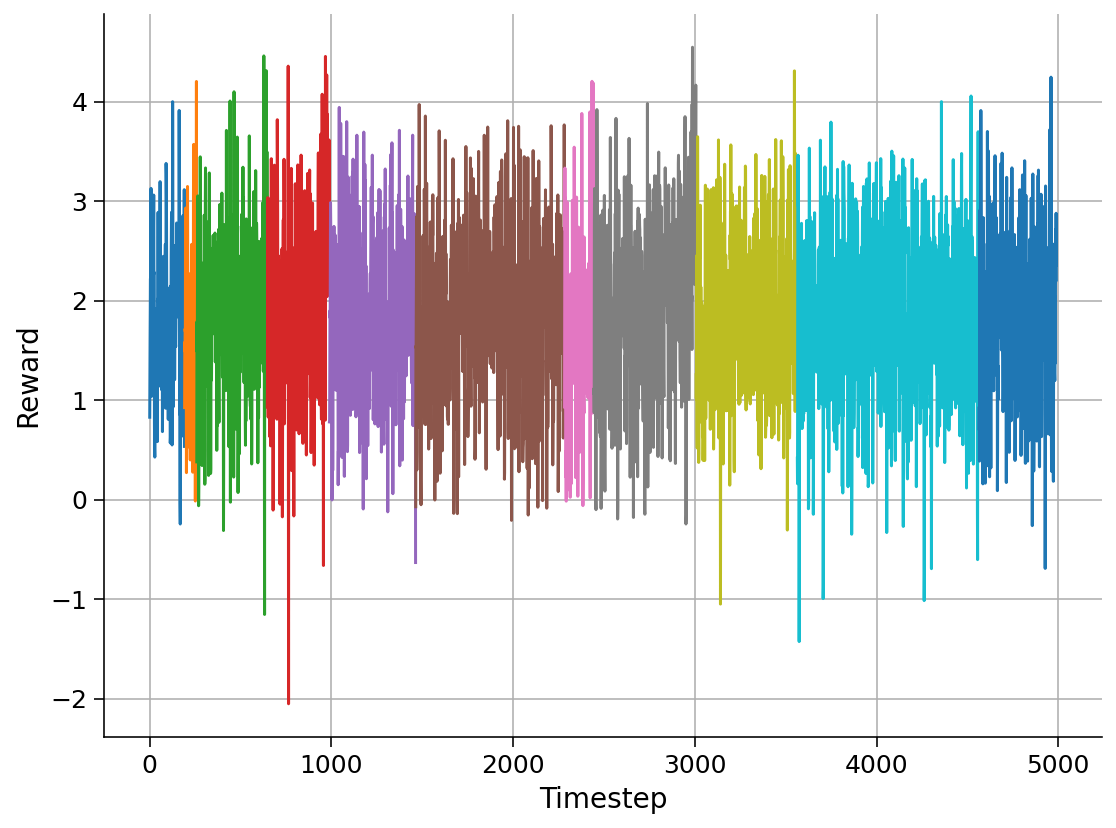

In [21]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
# plt.legend()
plt.show()

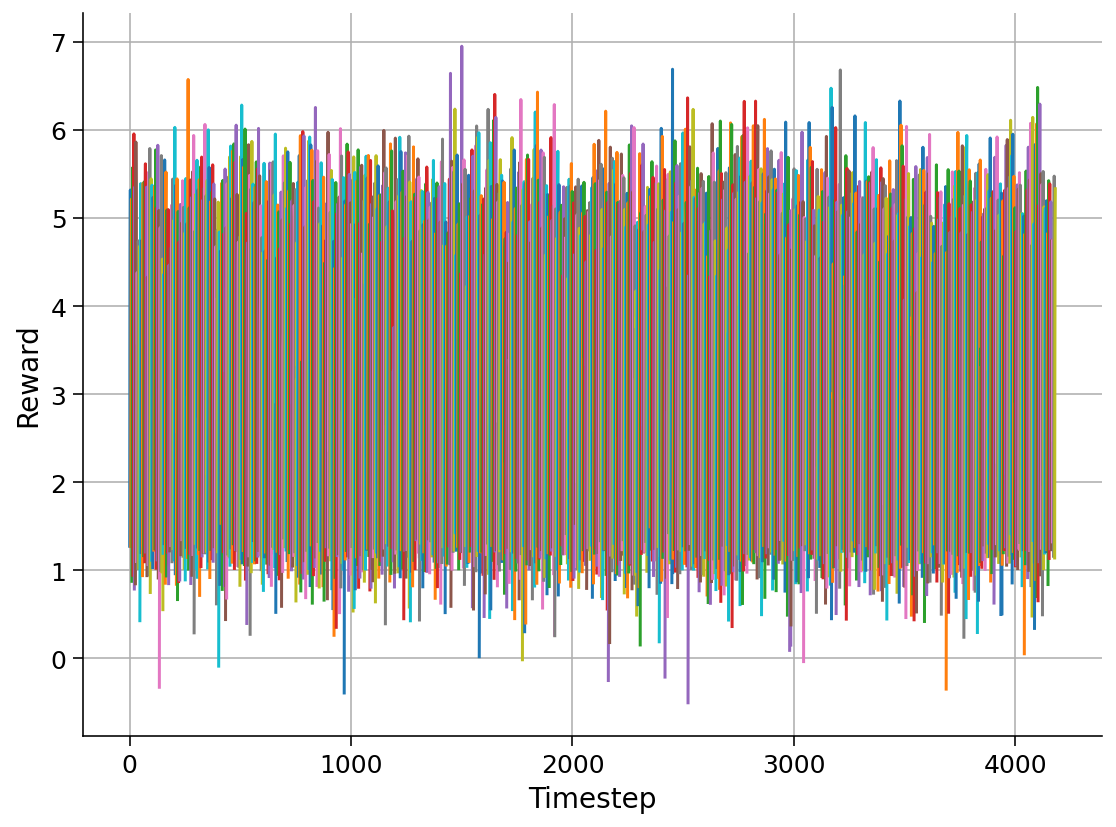

In [15]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
# plt.legend()
plt.show()

## Total reward

Finally, let's print the total reward for the test episodes

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")
  print(episode)

Total reward in episode 0: 25.35
[0.1749575436115265, -0.04306655004620552, 1.7009981870651245, 1.6138447523117065, 1.5192420482635498, 1.3619751930236816, 1.4140162467956543, 1.3214564323425293, 1.5737478733062744, 1.3135113716125488, 1.7486906051635742, 0.6932489275932312, 0.5800824761390686, 0.5899048447608948, 0.4848902225494385, 0.6195218563079834, 0.5924112796783447, 0.6443418264389038, 0.6441595554351807, 0.5845922827720642, 0.5935423374176025, 0.669916033744812, 0.5774287581443787, 0.5508073568344116, 0.4977096617221832, 0.5949108004570007, 0.5873682498931885, 0.4397437870502472, 0.5762693285942078, 0.5385064482688904, 1.1526986360549927, -0.5569509863853455]
Total reward in episode 1: 27.17
[-0.11309020966291428, 1.8208811283111572, 1.7534842491149902, 1.537154197692871, 1.3995294570922852, 1.366845965385437, 1.3496185541152954, 1.5314466953277588, 1.7166441679000854, 1.3044507503509521, 0.42878493666648865, 0.547135055065155, 0.8320369124412537, 0.7865059971809387, 0.71351748

## Saving and restoring training checkpoints to/from Google Drive

To avoid losing the training checkpoints during runtime restart, follow these steps:

In [17]:
# from google.colab import drive
# %cd /content/drive/My\ Drive/
!pwd
!ls


/home/tpremrud/proj1/NMA DL
 acme_ckpt   bullet3  'DL_robolympics (3).ipynb'   robolympics-main


### 1. Mount drive to temporarily save checkpoints

In [ ]:
# Mount drive. -- You may want to add your gDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. BEFORE restarting the runtime, save checkpoint to drive

In [18]:
# Save agent checkpoint to drive.
# dst = '/root/drive/MyDrive/acme_ckpt/D4PG_1m_noJump_noHowFar' 
# This means usage of D4PG agent, 1 million steps, jump and how_far = 0.0
save_ckpt_to_drive(agent, dst = '/home/tpremrud/proj1/NMA DL/acme_ckpt/D4PG_1m_noJump_noHowFar')

Saved /home/tpremrud/acme/1443b6b0-fbe4-11eb-9caa-f85971584e63/checkpoints/d4pg_learner to /home/tpremrud/proj1/NMA DL/acme_ckpt/D4PG_1m_noJump_noHowFar


In [ ]:
!ls "/root/drive/MyDrive/acme_ckpt"

ls: cannot access '/root/drive/MyDrive/acme_ckpt': No such file or directory


### 3. AFTER restarting the runtime, restore checkpoint from drive

To restore a checkpoint in the restarted Colab runtime:

1.   Re-install all the libraries and run all the cells as before, including the agent instantiation, **except** the training cell. 
2.   Run the cell below.
3.   Run the cell that instantiates the agent **again**.

In [14]:
# Restore checkpoint from drive.
restore_ckpt_from_drive(agent, src = '/home/tpremrud/proj1/NMA DL/acme_ckpt/D4PG_1m_noJump_noHowFar')

Restored /home/tpremrud/acme/aea3bc78-fbe4-11eb-9caa-f85971584e63/checkpoints/d4pg_learner from /home/tpremrud/proj1/NMA DL/acme_ckpt/D4PG_1m_noJump_noHowFar


### 4. Optionally, unmount drive

In [ ]:
# Unmount drive.
drive.flush_and_unmount()

In [ ]:
# Delete all stuff inside acme_ckpt
!rm "/root/drive/MyDrive/acme_ckpt/checkpoint"
!rm "/root/drive/MyDrive/acme_ckpt/ckpt-16.data-00000-of-00002"
!rm "/root/drive/MyDrive/acme_ckpt/ckpt-16.data-00001-of-00002"
!rm "/root/drive/MyDrive/acme_ckpt/ckpt-16.index"
!ls "/root/drive/MyDrive/acme_ckpt"

# Optional: Delete the folder
# %rm -rf "/root/drive/MyDrive/acme_ckpt"

rm: cannot remove '/root/drive/MyDrive/acme_ckpt/checkpoint': No such file or directory
rm: cannot remove '/root/drive/MyDrive/acme_ckpt/ckpt-16.data-00000-of-00002': No such file or directory
rm: cannot remove '/root/drive/MyDrive/acme_ckpt/ckpt-16.data-00001-of-00002': No such file or directory
rm: cannot remove '/root/drive/MyDrive/acme_ckpt/ckpt-16.index': No such file or directory


---
# Examples of two additional agents:

## DMPO agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_dmpo(action_spec)

# Create agent.
agent = DistributionalMPO(environment_spec=env_spec,
                          policy_network=policy_network,
                          critic_network=critic_network,
                          observation_network=tf2_utils.batch_concat,
                          policy_optimizer=policy_optimizer,
                          critic_optimizer=critic_optimizer,
                          logger=learner_logger,
                          checkpoint=checkpoint)

## DDPG agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_ddpg(action_spec)

# Create agent.
agent = DDPG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network= tf2_utils.batch_concat, # Identity Op.
             logger=learner_logger,
             checkpoint=checkpoint)

---
# Good luck :)